Preview of the dataset:


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


Number of rows and columns: (10000, 14)

Column info:
tau1     float64
tau2     float64
tau3     float64
tau4     float64
p1       float64
p2       float64
p3       float64
p4       float64
g1       float64
g2       float64
g3       float64
g4       float64
stab     float64
stabf     object
dtype: object

Missing values in each column:
tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

Class distribution of the target variable (stabf):
stabf
unstable    6380
stable      3620
Name: count, dtype: int64


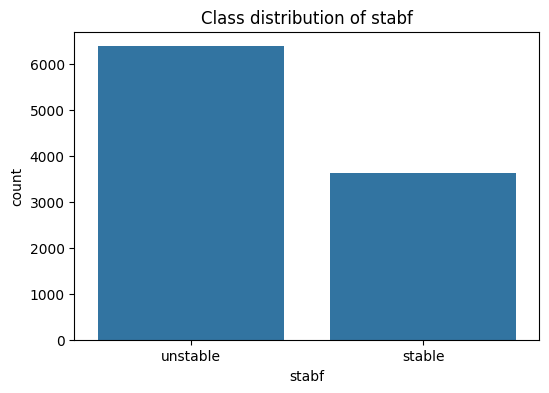

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# loading the dataset
df = pd.read_csv("/content/dataset.csv")

# taking a quick look at the first few rows
print("Preview of the dataset:")
display(df.head())

# checking the shape of the dataset
print("Number of rows and columns:", df.shape)

# checking the column data types
print("\nColumn info:")
print(df.dtypes)

# checking for missing values across all columns
print("\nMissing values in each column:")
print(df.isnull().sum())

# checking the class distribution for the target 'stabf'
print("\nClass distribution of the target variable (stabf):")
print(df['stabf'].value_counts())

# plotting the class distribution for a visual sense
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='stabf')
plt.title("Class distribution of stabf")
plt.show()


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# making a copy of the dataframe
data = df.copy()

# encoding the target column so ANN can understand it
label_encoder = LabelEncoder()
data['stabf'] = label_encoder.fit_transform(data['stabf'])

# 0 = stable, 1 = unstable
print("Encoded target classes:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# separating features and target
X = data.drop(['stab', 'stabf'], axis=1)   # dropping both targets and keeping only input features
y = data['stabf']

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# splitting into training and testing sets
# using 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

# scaling the features because ANN performs better when inputs are normalized
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling completed.")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


Encoded target classes: {'stable': np.int64(0), 'unstable': np.int64(1)}
Shape of X (features): (10000, 12)
Shape of y (target): (10000,)
Training set size: (8000, 12)
Testing set size: (2000, 12)
Scaling completed.
X_train_scaled shape: (8000, 12)
X_test_scaled shape: (2000, 12)


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# computing class weights so the model doesn't get biased toward the majority class
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# putting the weights into a dictionary since Keras expects that format
class_weights = {i: weights[i] for i in range(len(weights))}
print("Class weights being used:")
print(class_weights)

Class weights being used:
{0: np.float64(1.3812154696132597), 1: np.float64(0.7836990595611285)}


## Baseline ANN Model (Simple Feedforward Network)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# creating a baseline neural network
model = Sequential()

# first hidden layer
model.add(Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)))

# second hidden layer
model.add(Dense(16, activation='relu'))

# output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# compiling the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# setting up early stopping so the model stops when validation loss stops improving
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# training the model
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6381 - loss: 0.6334 - val_accuracy: 0.8031 - val_loss: 0.4179
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8084 - loss: 0.4026 - val_accuracy: 0.8131 - val_loss: 0.3736
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8496 - loss: 0.3227 - val_accuracy: 0.8419 - val_loss: 0.3229
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8600 - loss: 0.2852 - val_accuracy: 0.8719 - val_loss: 0.2768
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8895 - loss: 0.2445 - val_accuracy: 0.8869 - val_loss: 0.2390
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9046 - loss: 0.2135 - val_accuracy: 0.8863 - val_loss: 0.2411
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9105 - loss: 0.2056 - val_accuracy: 0.9013 - val_loss: 0.2081
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9163 - loss: 0.1877 - val_accurac

Test Accuracy: 0.9599999785423279
Test Loss: 0.1040496677160263


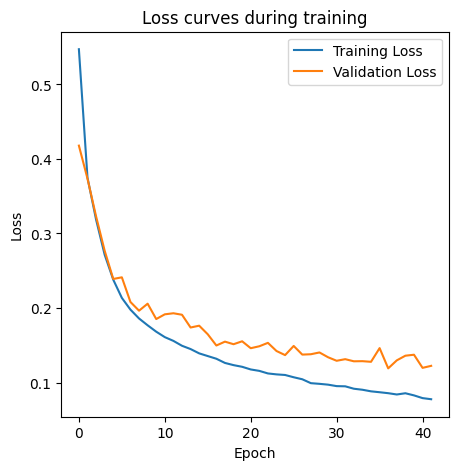

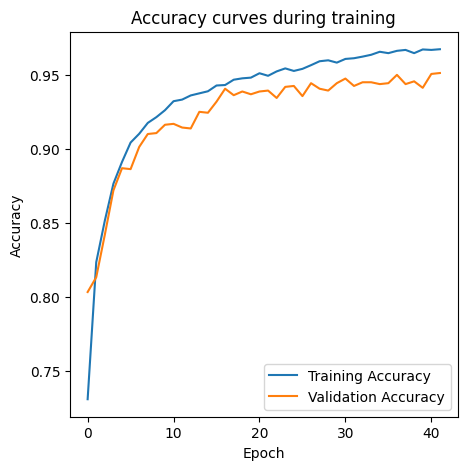

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       724
           1       0.96      0.97      0.97      1276

    accuracy                           0.96      2000
   macro avg       0.96      0.95      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

# plotting training and validation loss
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss curves during training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plotting training and validation accuracy
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy curves during training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# generating predictions (probabilities)
y_pred_prob = model.predict(X_test_scaled)

# converting probabilities to class labels
y_pred = (y_pred_prob >= 0.5).astype(int)

# printing classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

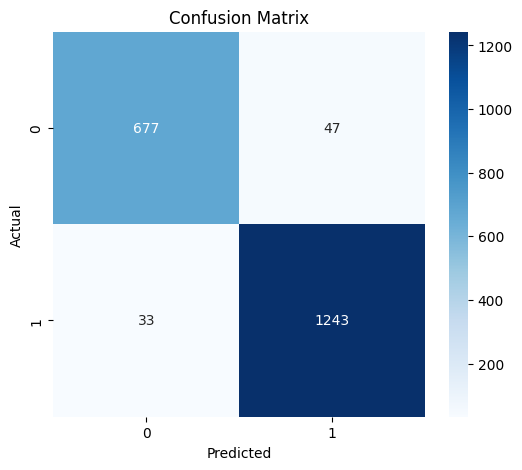

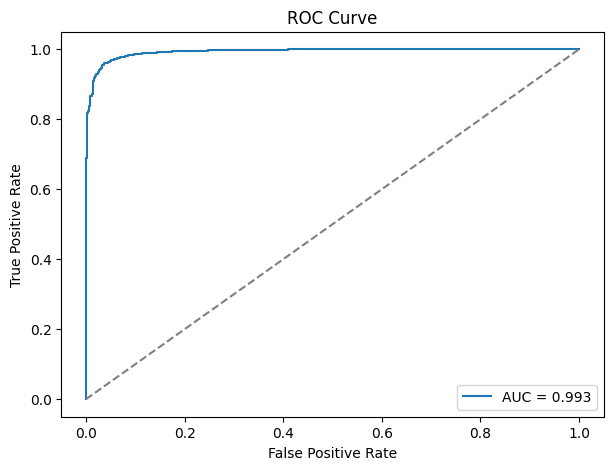

AUC Score: 0.9928525346819308


In [8]:

# visualising the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# computing the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# plotting ROC curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("AUC Score:", roc_auc)


## ANN with Batch Norm + Dropout

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# building a deeper neural network with normalization and dropout
model2 = Sequential()

# first hidden layer with more neurons
model2.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# second hidden layer
model2.add(Dense(32, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))

# third hidden layer
model2.add(Dense(16, activation='relu'))
model2.add(BatchNormalization())

# output layer
model2.add(Dense(1, activation='sigmoid'))

# compiling the model
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model2.summary())

# early stopping again for safety
early_stop2 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# training the model
history2 = model2.fit(
    X_train_scaled,
    y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop2],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,681 (14.38 KB)

 Non-trainable params: 224 (896.00 B)

None
Epoch 1/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6053 - loss: 0.6871 - val_accuracy: 0.8188 - val_loss: 0.4492
Epoch 2/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7870 - loss: 0.4439 - val_accuracy: 0.8381 - val_loss: 0.3666
Epoch 3/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8142 - loss: 0.4112 - val_accuracy: 0.8606 - val_loss: 0.3011
Epoch 4/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8353 - loss: 0.3547 - val_accuracy: 0.8819 - val_loss: 0.2686
Epoch 5/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8340 - loss: 0.3555 - val_accuracy: 0.8931 - val_loss: 0.2505
Epoch 6/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8602 - loss: 0.3172 - val_accuracy: 0.9069 - val_loss: 0.2303
Epoch 7/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8670 - loss: 0.3015 - val_accuracy: 0.9137 - val_loss: 0.2187
Epoch 8/60
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8735 - loss: 0.2855 - val_accurac

Model 2 - Test Accuracy: 0.9539999961853027
Model 2 - Test Loss: 0.1218385398387909


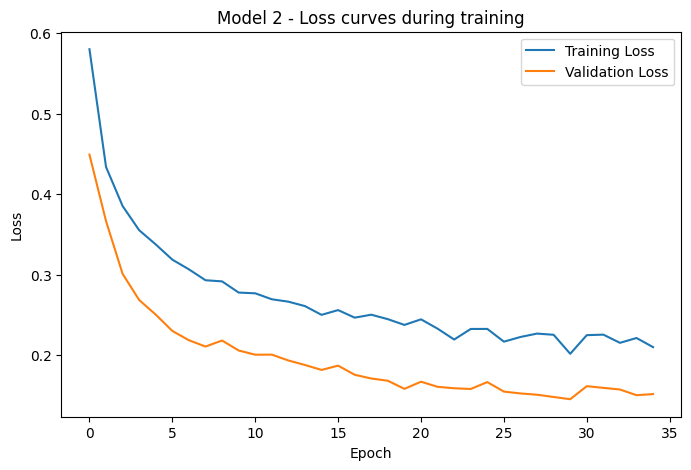

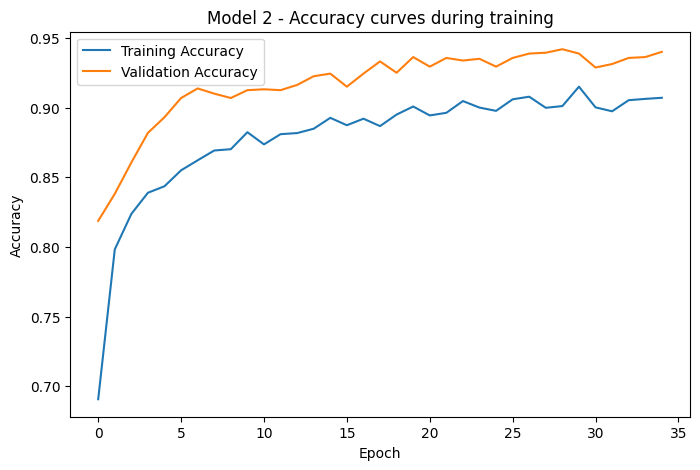

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Model 2 - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       724
           1       0.98      0.94      0.96      1276

    accuracy                           0.95      2000
   macro avg       0.95      0.96      0.95      2000
weighted avg       0.96      0.95      0.95      2000



In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# evaluating Model 2 on the test set
test_loss2, test_acc2 = model2.evaluate(X_test_scaled, y_test, verbose=0)
print("Model 2 - Test Accuracy:", test_acc2)
print("Model 2 - Test Loss:", test_loss2)

# plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title("Model 2 - Loss curves during training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot training and validation accuracy
plt.figure(figsize=(8,5))
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model 2 - Accuracy curves during training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# predictions: probability output
y_pred_prob2 = model2.predict(X_test_scaled)

# converting probabilities to class labels
y_pred2 = (y_pred_prob2 >= 0.5).astype(int)

# classification report
print("\nModel 2 - Classification Report:")
print(classification_report(y_test, y_pred2))


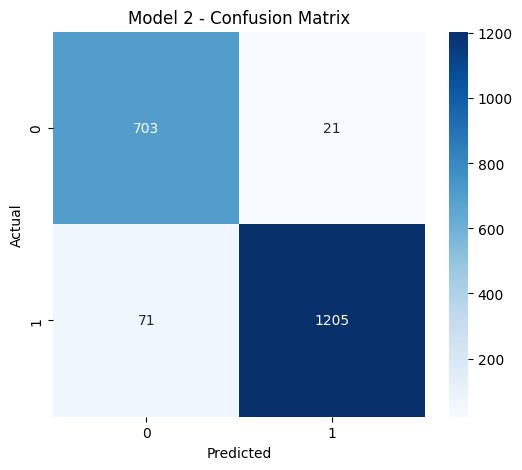

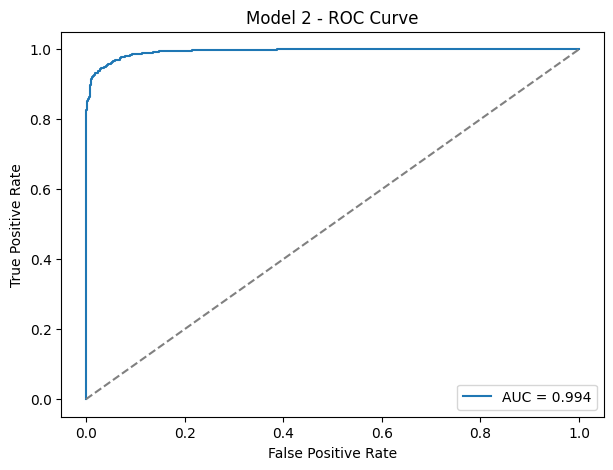

Model 2 - AUC Score: 0.9937996847884446


In [11]:
# confusion matrix
cm2 = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title("Model 2 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and AUC
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(7,5))
plt.plot(fpr2, tpr2, label=f"AUC = {roc_auc2:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.title("Model 2 - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("Model 2 - AUC Score:", roc_auc2)
